In [2]:
## Google location history analysis
## Mostly distance parameter recorded by google

## Venu Thatikonda

setwd("/Users/venu/Desktop/work/blog/glh_22122018")

suppressPackageStartupMessages(library(jsonlite))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(plyr))
suppressPackageStartupMessages(library(raster))
suppressPackageStartupMessages(library(extrafont))
suppressPackageStartupMessages(library(repr))

suppressMessages(loadfonts())

## my own theme
theme_vt <- function () { 
  theme_bw(base_size=18, base_family="Palatino") %+replace% 
    theme(
      panel.background  = element_blank(),
      legend.background = element_rect(fill="transparent", colour=NA),
      legend.key = element_rect(fill="transparent", colour=NA),
      panel.border = element_rect(fill = NA, color = "black", size = 1.2),
      axis.text = element_text(size = 14, color = "black")
    )
}

## read json file
glh_dat = fromJSON("Takeout/LocationHistory/LocationHistory.json")

glh_locations = glh_dat$locations

## change milliseconds time-scale to regulat format

glh_locations$regular_time = as.POSIXct(as.numeric(glh_dat$locations$timestampMs)/1000, origin="1970-01-01")

## also convert lat, lon from E7 format to regulat format (GPS coordinates)

glh_locations$lat = glh_locations$latitudeE7 / 1e7
glh_locations$lon = glh_locations$longitudeE7 / 1e7

## add month and day of the week

glh_locations$day = weekdays(as.Date(glh_locations$regular_time))
glh_locations$month = months(as.Date(glh_locations$regular_time))

## model activity-type and it's confidence
act <- laply(glh_locations$activity, function(f) {
  if(is.null(f[[1]])) data.frame(activity=NA,confidence=NA,stringsAsFactors=F) else data.frame(activity=f[[2]][[1]][[1]][1],confidence=f[[2]][[1]][[2]][1],stringsAsFactors=F)
},.progress="none")


glh_clean_01 = cbind(glh_locations %>% dplyr::select(-c(activity)), act %>% as.data.frame()) %>% 
  dplyr::rename(activity_confidence = confidence) %>% 
  dplyr::select(regular_time, accuracy, day, month, activity, activity_confidence, velocity, lat, lon) 

head(glh_clean_01)


regular_time,accuracy,day,month,activity,activity_confidence,velocity,lat,lon
2018-12-22 11:04:05,16,Saturday,December,NA,NA,NA,49.40180,8.680858
2018-12-22 11:02:21,15,Saturday,December,NA,NA,NA,49.40179,8.680845
2018-12-22 11:00:21,14,Saturday,December,UNKNOWN,31,NA,49.40178,8.680898
2018-12-22 10:58:49,15,Saturday,December,TILTING,100,NA,49.40183,8.680859
2018-12-22 10:56:50,16,Saturday,December,TILTING,100,NA,49.40186,8.680846
2018-12-22 10:55:25,15,Saturday,December,TILTING,100,NA,49.40188,8.680831


Warning message in .pointsToMatrix(p1):
“NAs introduced by coercion”Warning message in .pointsToMatrix(p1):
“NAs introduced by coercion”Warning message:
“Expected 2 pieces. Additional pieces discarded in 168606 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”

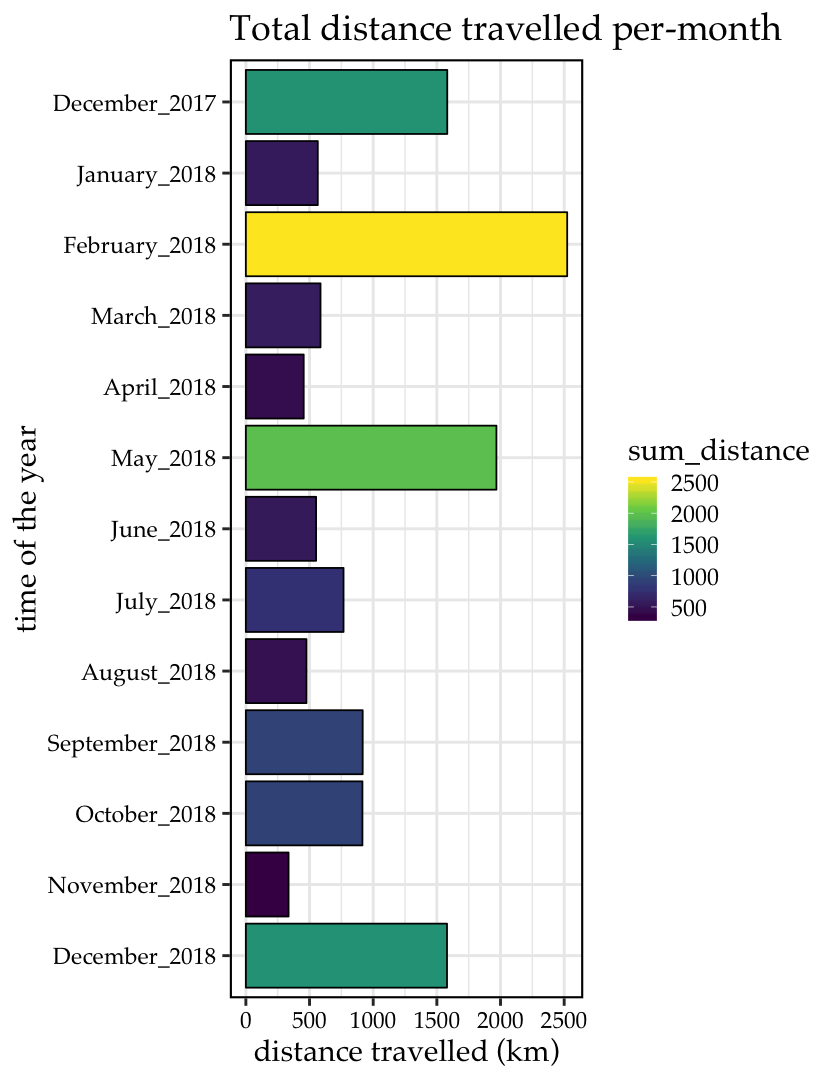

In [6]:
## Used python script to get city name from lat, long coordinates
## Check in this repo: LatLon_to_city.ipynb

city_names = data.table::fread("glh_clean_v01_LatLon_table_citynames.txt", header = TRUE)

colnames(city_names) = c("original_lat", "original_lon", "admin1", "admin2", "cc", "close_lat", "close_lon", "name")

## add other info

glh_clean_02 = cbind(glh_clean_01, city_names %>% as.data.frame()) %>% 
  dplyr::select(-c(original_lat, original_lon, admin1, admin2)) %>% 
  dplyr::rename(country_code = cc)

## add per-day distance
## Function borrowed from: https://shiring.github.io/maps/2016/12/30/Standortverlauf_post

# Shifting vectors for latitude and longitude to include end position
shift.vec <- function(vec, shift){
  if (length(vec) <= abs(shift)){
    rep(NA ,length(vec))
  } else {
    if (shift >= 0) {
      c(rep(NA, shift), vec[1:(length(vec) - shift)]) }
    else {
      c(vec[(abs(shift) + 1):length(vec)], rep(NA, abs(shift)))
    }
  }
}

glh_clean_02$lat.p1 = shift.vec(glh_clean_02$lat, -1)
glh_clean_02$lon.p1 = shift.vec(glh_clean_02$lon, -1)

## calculate distances, in meters
glh_clean_02$dist.to.prev <- apply(glh_clean_02, 1, FUN = function(row) {
  pointDistance(c(as.numeric(as.character(row["lat.p1"])),
                  as.numeric(as.character(row["lon.p1"]))),
                c(as.numeric(as.character(row["lat"])), as.numeric(as.character(row["lon"]))),
                lonlat = T) # Parameter 'lonlat' has to be TRUE!
})

## add year
glh_clean_02 = glh_clean_02 %>% dplyr::mutate(my_time = regular_time) %>% 
  tidyr::separate(col = "my_time", into = c("year", "rest"), sep = "-") %>% 
  dplyr::select(-c(rest))

## there is one data point with NA in distance, remove it
glh_clean_02 = glh_clean_02 %>% dplyr::filter(dist.to.prev != "NA")

## distance to km
glh_clean_02$dist.to.prev = glh_clean_02$dist.to.prev/1000

#####################################
## Filtering and final cleaning
## accuracy < 1000
## acitvity != NA
## acitivity_confidence != NA & > 10

glh_clean_03 = glh_clean_02 %>% 
  dplyr::filter(activity != "NA" & activity_confidence != "NA" & activity_confidence > 10)

# > glh_clean_03 %>% dim
# [1] 106707     17

## For year-2018, I hhave the data until December-21, 2018.
## Let's keep the same date in 2017, so we are looking at particular period

glh_clean_04 = glh_clean_03 %>% 
  dplyr::filter(regular_time < "2017-12-23" | regular_time >= "2018-01-01") 

## per-year distance
## per-year-per-month distance
## boxplot of per-dat distance for each year

## per-year distance

per_year_distance = glh_clean_03 %>% 
  dplyr::select(month, year, dist.to.prev) %>% 
  dplyr::mutate(time_of_year = paste0(month, "_", year)) %>% 
  dplyr::select(time_of_year, dist.to.prev) %>% 
  dplyr::group_by(time_of_year) %>% 
  dplyr::summarise(sum_distance = sum(dist.to.prev)) %>% 
  as.data.frame()
  
## order months

per_year_distance$time_of_year = factor(per_year_distance$time_of_year, levels = rev(c("December_2017", "January_2018",
                                                                                   "February_2018", "March_2018",
                                                                                   "April_2018", "May_2018",
                                                                                   "June_2018", "July_2018",
                                                                                   "August_2018", "September_2018",
                                                                                   "October_2018", "November_2018", "December_2018")))
  

## plot
ggplot(per_year_distance, aes(time_of_year, sum_distance, fill = sum_distance))+
  geom_bar(stat = "identity", color = "black")+
  scale_fill_viridis_c()+
  coord_flip()+
  ylab("distance travelled (km)")+
  xlab("time of the year")+
  theme_vt()+
  ggtitle("Total distance travelled per-month")



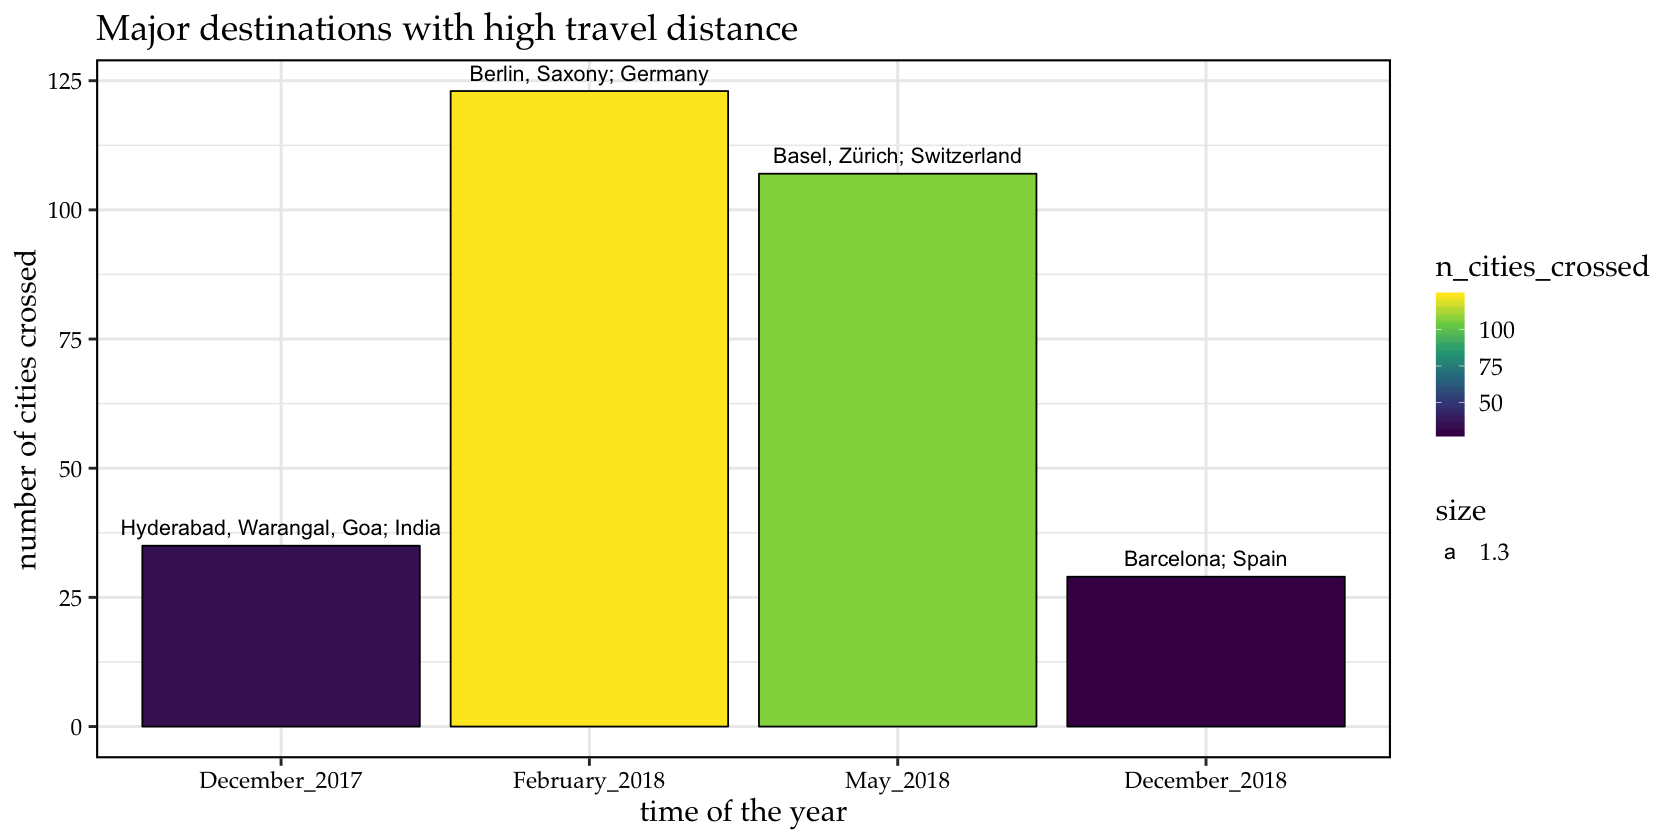

In [12]:
## notes:
## Feb and May 2018 is higher (also December, 2017 & 2018)
## What did I do during that period?
## Check cities I travelled to?

high_distance_cities = glh_clean_03 %>% 
  dplyr::filter(month == "February" | month == "May" | month == "December") %>% 
  dplyr::select(month, name, year) %>% 
  dplyr::mutate(time_of_year = paste0(month, "_", year)) %>% 
  dplyr::select(time_of_year, name) %>% 
  unique()
  
## number of cities crossed and major destinations

high_distance_cities_dest = high_distance_cities %>% 
  dplyr::select(time_of_year) %>% 
  dplyr::group_by(time_of_year) %>% 
  dplyr::count() %>% as.data.frame() %>% 
  dplyr::rename(n_cities_crossed = n)

high_distance_cities_dest$major_destinations = c("Hyderabad, Warangal, Goa; India",
                                                 "Barcelona; Spain",
                                                 "Berlin, Saxony; Germany",
                                                 "Basel, Zürich; Switzerland")

## fix x-axis
high_distance_cities_dest$time_of_year = factor(high_distance_cities_dest$time_of_year,
                                                levels = c("December_2017", "February_2018", "May_2018", "December_2018"))


options(repr.plot.width = 14, repr.plot.height = 7)
ggplot(high_distance_cities_dest, aes(time_of_year, n_cities_crossed, fill = n_cities_crossed))+
  geom_bar(stat = "identity", color = "black")+
  scale_fill_viridis_c()+
  ylab("number of cities crossed")+
  xlab("time of the year")+
  geom_text(aes(label=major_destinations, size = 1.3), position=position_dodge(width=0.9), vjust=-0.7)+
  theme_vt()+
  ggtitle("Major destinations with high travel distance")
  

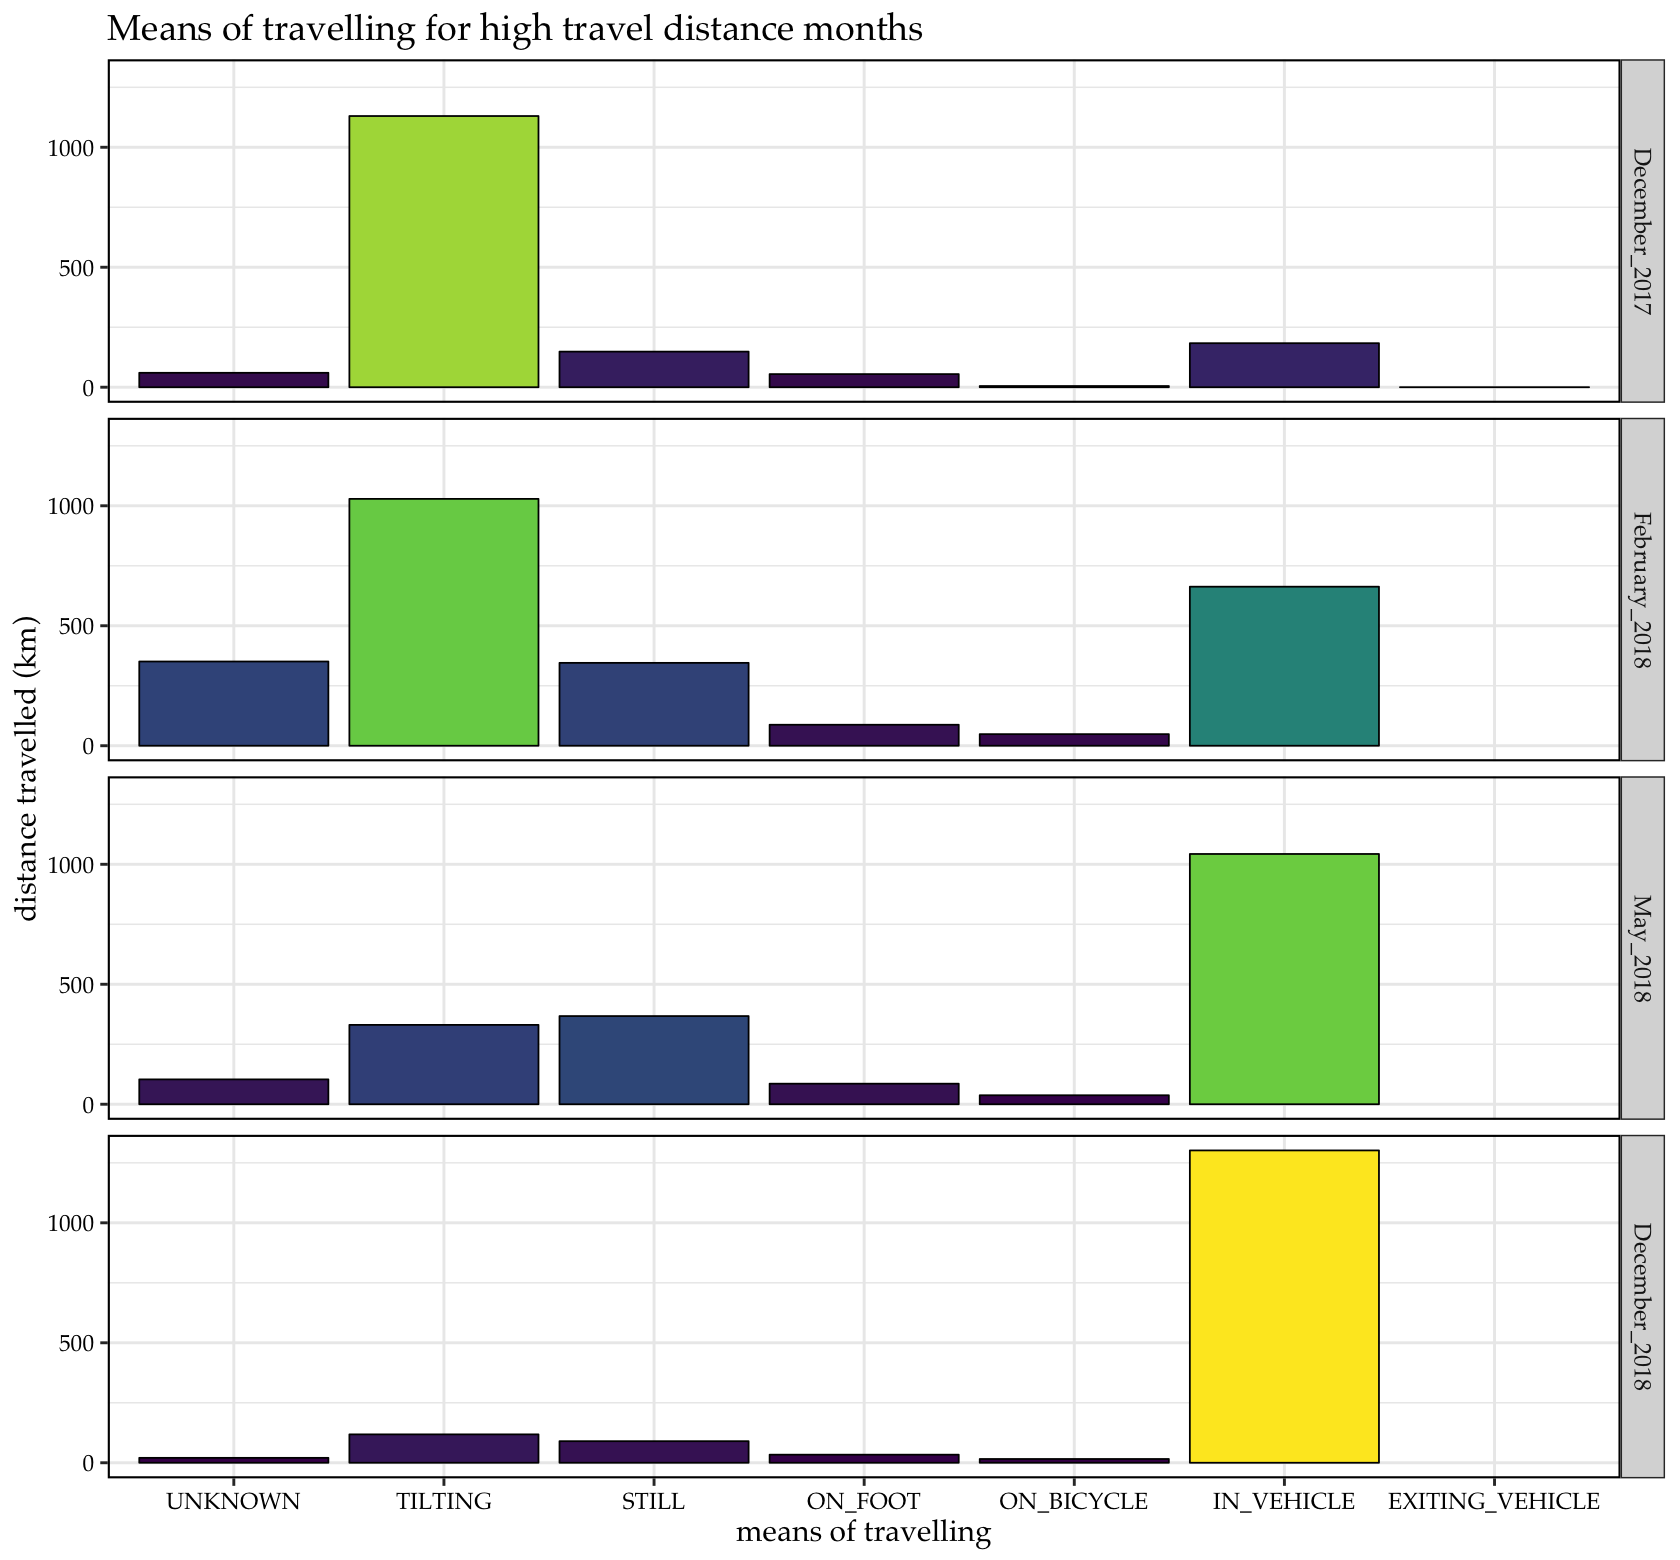

In [16]:
## now look for activity-type in each of the high distance months
## distance travelled by each of the means

high_distance_activity = glh_clean_03 %>% 
  dplyr::filter(month == "February" | month == "May" | month == "December") %>%
  dplyr::select(month, year, activity, dist.to.prev) %>% 
  dplyr::mutate(time_of_year = paste0(month, "_", year)) %>% 
  dplyr::select(-c(month, year)) 

high_distance_activity$activity = as.character(high_distance_activity$activity)

high_distance_activity_distance = high_distance_activity %>% 
  dplyr::group_by(time_of_year, activity) %>% 
  dplyr::summarise(sum_distance = sum(dist.to.prev)) %>% 
  as.data.frame()

## factorize activity type
## 
high_distance_activity_distance$activity = factor(high_distance_activity_distance$activity,
                                                  levels = c("UNKNOWN", "TILTING", "STILL", "ON_FOOT", "ON_BICYCLE", "IN_VEHICLE", "EXITING_VEHICLE"))

high_distance_activity_distance$time_of_year = factor(high_distance_activity_distance$time_of_year, levels = c("December_2017", "February_2018", "May_2018", "December_2018"))

options(repr.plot.width = 14, repr.plot.height = 13)
ggplot(high_distance_activity_distance, aes(activity, sum_distance, fill = sum_distance))+
  geom_bar(stat = "identity", color = "black")+
  scale_fill_viridis_c()+
  facet_grid(time_of_year ~ .)+
  theme_vt()+
  theme(legend.position = "none")+
  ylab("distance travelled (km)")+
  xlab("means of travelling")+
  ggtitle("Means of travelling for high travel distance months")


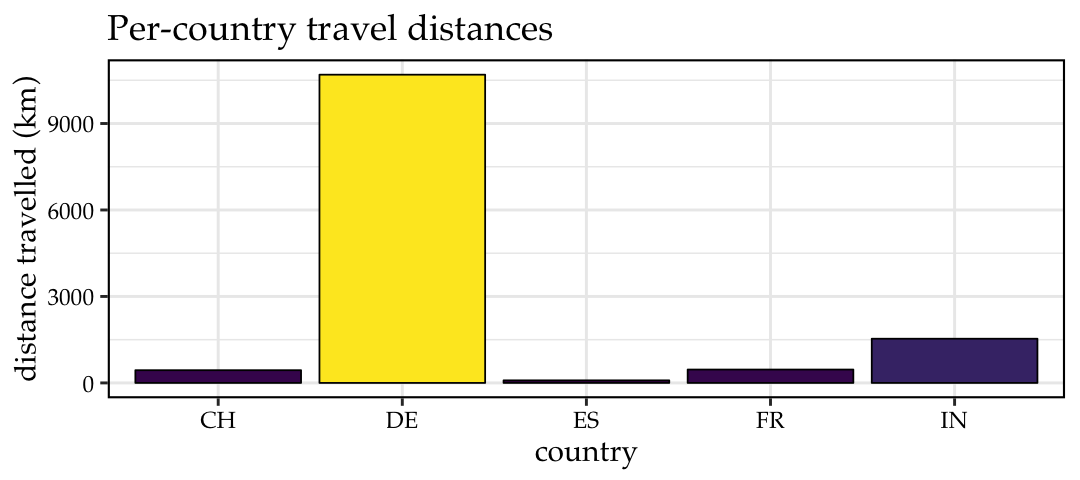

In [23]:
## COUNTRY WISE DISTANCE
## Now look for distance country-wise

country_distance = glh_clean_03 %>% 
  dplyr::select(country_code, dist.to.prev) %>% 
  dplyr::group_by(country_code) %>% 
  dplyr::summarise(sum_distance = sum(dist.to.prev)) %>% 
  as.data.frame()

options(repr.plot.width = 9, repr.plot.height = 4)
ggplot(country_distance, aes(country_code, sum_distance, fill = sum_distance))+
  geom_bar(stat = "identity", color = "black")+
  scale_fill_viridis_c()+
  theme_vt()+
  theme(legend.position = "none")+
  ylab("distance travelled (km)")+
  xlab("country")+
  ggtitle("Per-country travel distances")


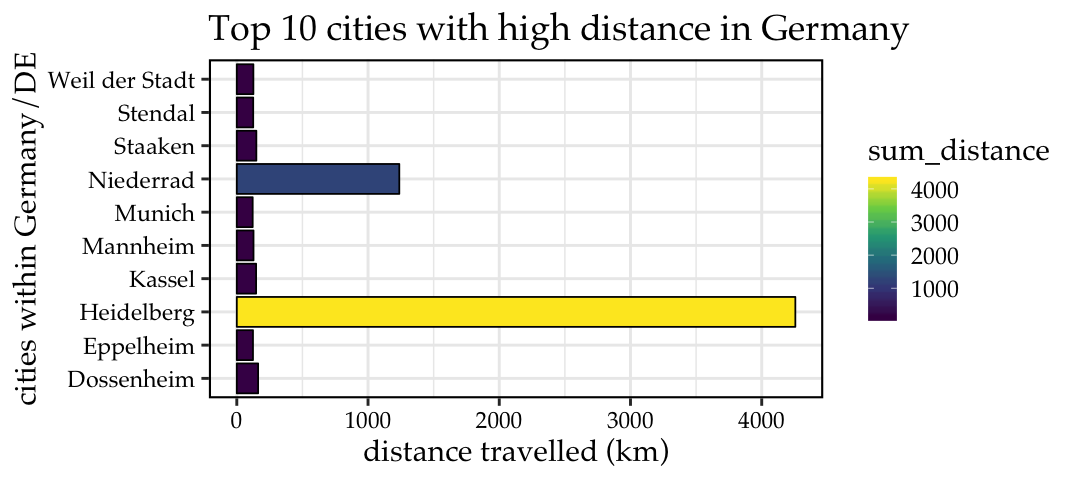

In [25]:
## distance travelled in each major city within germany, in 2018
de_distance_percity = glh_clean_03 %>% 
  dplyr::filter(country_code == "DE" & year == 2018) %>%
  dplyr::select(name, dist.to.prev) %>% 
  dplyr::group_by(name) %>% 
  dplyr::summarise(sum_distance = sum(dist.to.prev)) %>% 
  dplyr::arrange(desc(sum_distance)) %>% head(n=10) %>% as.data.frame()

ggplot(de_distance_percity, aes(name, sum_distance, fill = sum_distance))+
  geom_bar(stat = "identity", color = "black")+
  scale_fill_viridis_c()+
  theme_vt()+
  xlab("cities within Germany/DE")+
  ylab("distance travelled (km)")+
  coord_flip()+
  ggtitle("Top 10 cities with high distance in Germany")

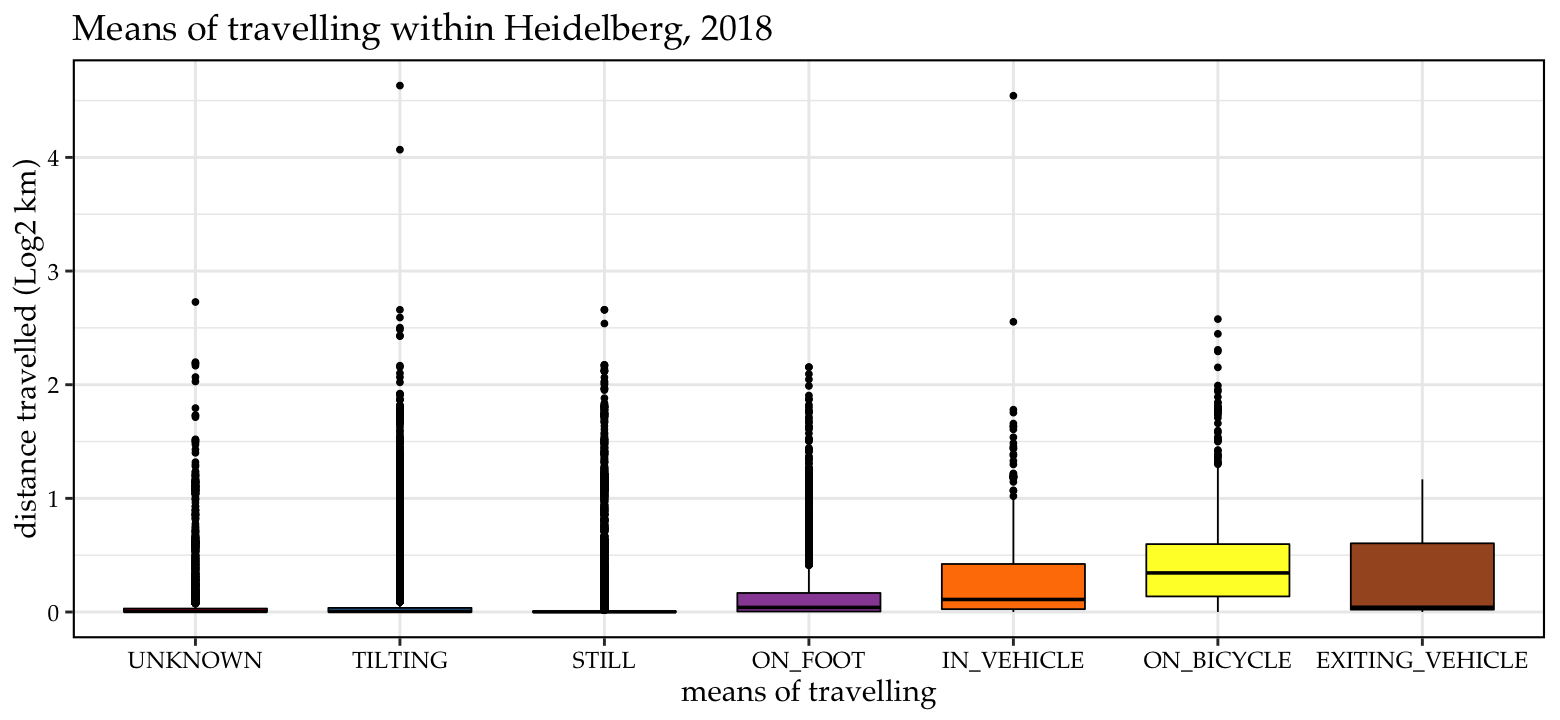

In [29]:
## what are my means of travelling within Heidelberg in 2018
## what is the distance distribution over days of a week
glh_clean_03$activity = as.character(glh_clean_03$activity)

hd_distance = glh_clean_03 %>% 
  dplyr::filter(name == "Heidelberg" & year == 2018) %>% 
  dplyr::select(activity, dist.to.prev) %>% 
  dplyr::mutate(log_distance = log2(dist.to.prev+1)) 

options(repr.plot.width = 13, repr.plot.height = 6)
ggboxplot(hd_distance, x = "activity", y = "log_distance", fill = "activity")+
  scale_fill_brewer(palette = "Set1")+
  theme_vt()+
  theme(legend.position = "none")+
  ylab("distance travelled (Log2 km)")+
  xlab("means of travelling")+
  ggtitle("Means of travelling within Heidelberg, 2018")

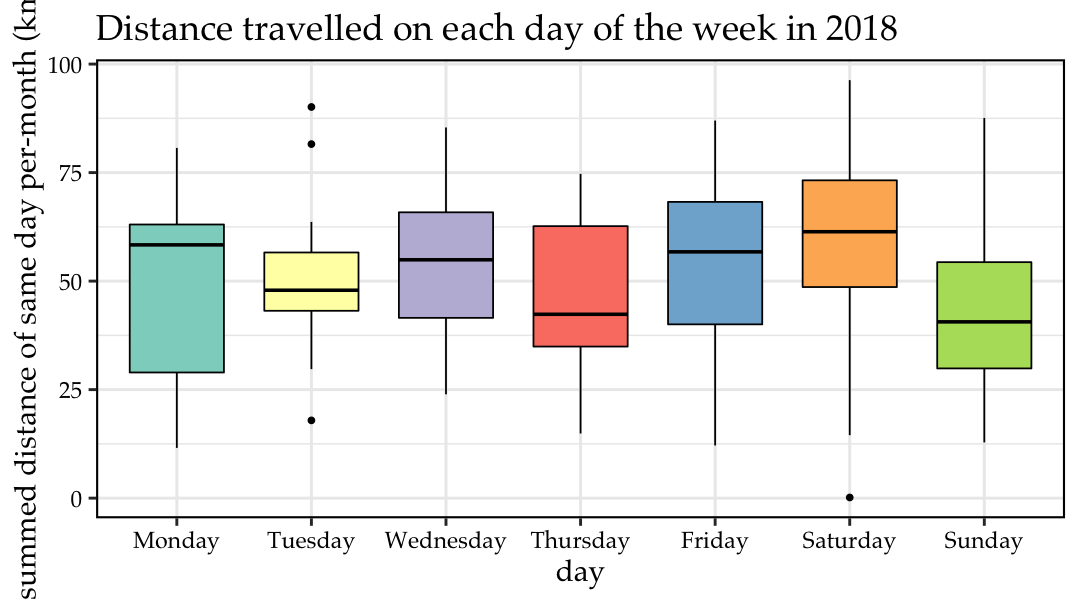

In [37]:
## distance distribution on ddifferent days of a week
## for each month sum_up distance on same-day

hd_weekday_2018_distance = glh_clean_03 %>% 
  dplyr::filter(name == "Heidelberg" & year == 2018) %>% 
  dplyr::select(day, month, dist.to.prev) %>% 
  dplyr::group_by(month, day) %>% 
  dplyr::summarise(sum_distance = sum(dist.to.prev)) %>%
  as.data.frame()
  
hd_weekday_2018_distance$day = factor(hd_weekday_2018_distance$day, levels = c("Monday", "Tuesday", 
                                                                               "Wednesday", "Thursday",
                                                                               "Friday", "Saturday", "Sunday"))
options(repr.plot.width = 9, repr.plot.height = 5)
ggboxplot(hd_weekday_2018_distance, x = "day", y = "sum_distance", fill = "day")+
  scale_fill_brewer(palette = "Set3")+
  theme_vt()+
  xlab("day")+
  ylab("summed distance of same day per-month (km)")+
  theme(legend.position = "none")+
  ggtitle("Distance travelled on each day of the week in 2018")

In [34]:
## we are done!
save.image("glh_22122018_R.ipynb.RData")